In [62]:
from PIL import Image
import numpy as np
import pydicom

In [49]:
def visualize_bbox_dicom(image_path, bounding_box):
    """
    Visualize a bounding box on an image.

    Parameters:
    image_path (string): The image path on which to draw the bounding box.
    bounding_box (list): The bounding box coordinates in the format [x1, y1, x2, y2, x3, y3, x4, y4].

    Returns:
    None
    """
    # Load the DICOM file
    dicom_image = pydicom.dcmread(image_path)
    
    # Access the pixel data and convert it to a NumPy array
    image = dicom_image.pixel_array
    
    # Normalize the image data to 0-255 if it's not already in this range
    if image.dtype == np.uint16:  # Common for DICOM images
        # Normalize to 0-255
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    elif image.dtype == np.float32 or image.dtype == np.float64:
        # Assuming the float range is 0.0-1.0, scale to 0-255 if not already
        if image.min() < 0 or image.max() > 1:
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    
    # Convert grayscale to RGB if the image is not in RGB format
    if len(image.shape) == 2:  # Image is grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Get the new image size from the image variable
    new_image_size = image.shape[:2]

    # Shift the x-coordinates to make the origin the center of the new image size
    bounding_box[::2] = [new_image_size[1] / 2 + coord for coord in bounding_box[::2]]

    # For y-coordinates, positive values mean going downward from the center
    bounding_box[1::2] = [new_image_size[0] / 2 + coord for coord in bounding_box[1::2]]

    # Convert the bounding box coordinates to integers
    bounding_box = [int(coord) for coord in bounding_box]
    
    # The bounding box coordinates are assumed to be in the format [x1, y1, x2, y2, x3, y3, x4, y4]
    points = np.array([[bounding_box[i], bounding_box[i + 1]] for i in range(0, len(bounding_box), 2)])

    # Draw the bounding box on the image with increased thickness and changed color
    cv2.polylines(image, [points], True, (255, 0, 0), 20)
    
    # Display the image
    plt.imshow(image)
    plt.show()

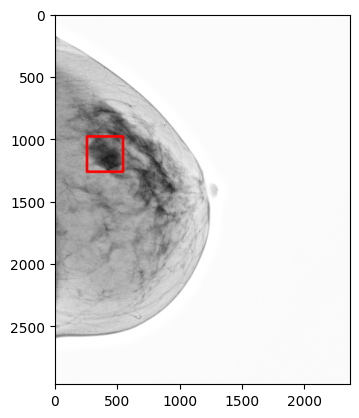

In [51]:
visualize_bbox_dicom(image_path, bounding_box)

In [54]:
def dicom_to_jpeg(dicom_path, jpeg_path):
    # Read the DICOM file
    dicom = pydicom.dcmread(dicom_path)

    # Extract the image data as a NumPy array
    image_array = dicom.pixel_array

    # Normalize the pixel values to the range [0, 255]
    image_array = (np.maximum(image_array, 0) / image_array.max()) * 255.0
    image_array = np.uint8(image_array)

    # Create a PIL image from the NumPy array
    image = Image.fromarray(image_array)

    # Save the image as JPEG
    image.save(jpeg_path)

In [60]:
def visualize_bbox_jpeg(jpeg_path, bounding_box_list):
    """
    Visualizes bounding boxes on a JPEG image. Each bounding box is defined by 8 points,
    representing the corners of a quadrilateral.

    Parameters:
    jpeg_path (str): The file path to the JPEG image.
    bounding_box_list (list): A list containing bounding box coordinates, 
                              with each bounding box defined by 8 points [x1, y1, x2, y2, x3, y3, x4, y4].
    """
    # Load the JPEG image
    image = cv2.imread(jpeg_path)
    
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw each bounding box on the image
    for bbox in bounding_box_list:
        # Convert the bounding box points into a format suitable for cv2.polylines
        points = np.array([[bbox[i], bbox[i + 1]] for i in range(0, len(bbox), 2)], np.int32)
        points = points.reshape((-1, 1, 2))
        # Draw the bounding box
        cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=20)

    # Display the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

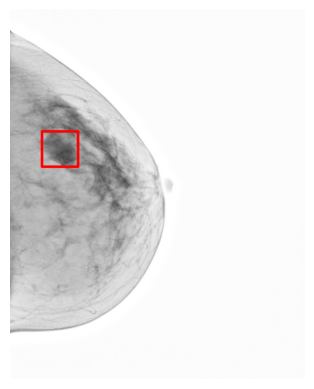

In [61]:
visualize_bbox_jpeg(jpeg_path,[ bounding_box])

In [64]:
def convert_dicom_directory(src_dir):
    # Traverse the directory structure
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.endswith('.dcm'):
                dicom_path = os.path.join(root, file)
                # Define the corresponding JPEG path
                jpeg_path = dicom_path.replace('.dcm', '.jpeg')

                # Convert DICOM to JPEG
                dicom_to_jpeg(dicom_path, jpeg_path)

                # Delete the original DICOM file
                os.remove(dicom_path)

## Resizing images

In [14]:
import os
import cv2

def resize_image(image_path, target_size=(640, 640)):
    """
    This function loads an image from the given file path, pads it to a square shape with zeros,
    and then resizes it to the target size.

    Parameters:
    image_path (str): The file path to the image.
    target_size (tuple): The target size in the format (width, height).

    Returns:
    np.array: The resized image.
    """
    # Load the image from the file path
    image = cv2.imread(image_path)

    # Determine the longer side to use as the size for both dimensions
    max_side = max(image.shape[:2])

    # Calculate padding for the top, bottom, left, and right
    top = (max_side - image.shape[0]) // 2
    bottom = max_side - image.shape[0] - top
    left = (max_side - image.shape[1]) // 2
    right = max_side - image.shape[1] - left

    # Apply padding to make the image square
    image_padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Resize the padded image to the target size
    resized_image = cv2.resize(image_padded, target_size)

    return resized_image

def copy_and_resize_images(src_dir, dest_dir):
    """
    Copy and resize all JPEG images from the source directory to the destination directory,
    maintaining the same folder structure.

    Parameters:
    src_dir (str): The source directory containing the images.
    dest_dir (str): The destination directory to save the resized images.
    """
    for root, _, files in os.walk(src_dir):
        for file in files:
            if file.lower().endswith('.jpeg'):
                src_image_path = os.path.join(root, file)
                relative_path = os.path.relpath(src_image_path, src_dir)
                dest_image_path = os.path.join(dest_dir, relative_path)

                # Create the destination directory if it doesn't exist
                os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

                # Check if the file already exists and rename if necessary
                base, ext = os.path.splitext(dest_image_path)
                counter = 1
                while os.path.exists(dest_image_path):
                    dest_image_path = f"{base}_{counter}{ext}"
                    counter += 1

                # Resize the image
                resized_image = resize_image(src_image_path)

                # Save the resized image in the destination directory
                cv2.imwrite(dest_image_path, resized_image)

In [16]:
import os

def remove_tfrecord_files(directory):
    """
    Remove all TFRecord files in the given directory and its subdirectories.

    Parameters:
    directory (str): The root directory to search for TFRecord files.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.tfrecord'):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11106-RCC.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11106-RMLO.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11158-RCC.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11158-RMLO.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11229-RCC.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11229-RMLO.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11234-RCC.tfrecord
Removed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords/test\Kategori2\11234-RM

In [20]:
import os

def rename_files_in_category(base_dir, category):
    category_path = os.path.join(base_dir, category)
    if not os.path.isdir(category_path):
        print(f"The specified category path does not exist: {category_path}")
        return
    
    for root, dirs, files in os.walk(category_path):
        if root == category_path:  # Skip the top-level category folder
            continue
        
        second_level_folder_name = os.path.basename(root)
        for file in files:
            if file.endswith(".tfrecord"):
                new_file_name = f"{second_level_folder_name}-{file}"
                old_file_path = os.path.join(root, file)
                new_file_path = os.path.join(root, new_file_name)
                os.rename(old_file_path, new_file_path)
                print(f'Renamed: {old_file_path} to {new_file_path}')


Renamed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12167\RCC.tfrecord to C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12167\12167-RCC.tfrecord
Renamed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12167\RMLO.tfrecord to C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12167\12167-RMLO.tfrecord
Renamed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12168\RCC.tfrecord to C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12168\12168-RCC.tfrecord
Renamed: C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_demo\dataset/tfrecords_2_640/train\Kategori5\12168\RMLO.tfrecord to C:/Users/abdulkadir\Documents\TensorFlow\workspace/training_dem

In [26]:
import os
import shutil
def move_files_up_and_cleanup(base_folder):
    """
    Moves all files in subfolders to one level up and deletes folders that are emptied after moving the files.
    !!! Rename the files before running this function to avoid overwriting files with the same name!!!

    Parameters:
    base_folder (str): The base folder containing the files in subfolders.
    """
    # Track empty directories to delete later
    empty_dirs = []

    # Walk through all the directories and subdirectories
    for root, _, files in os.walk(base_folder, topdown=False):
        if root == base_folder:
            continue  # Skip the base folder itself

        for file in files:
            # Construct the old and new file paths
            old_file_path = os.path.join(root, file)
            new_file_path = os.path.join(os.path.dirname(root), file)

            # Move the file
            shutil.move(old_file_path, new_file_path)
            print(f"Moved: {old_file_path} -> {new_file_path}")

        # Check if the current directory is empty
        if not os.listdir(root):
            empty_dirs.append(root)

    # Delete the empty directories
    for empty_dir in empty_dirs:
        os.rmdir(empty_dir)
        print(f"Deleted empty directory: {empty_dir}")


Moved: C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11030\11030-RCC.tfrecord -> C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11030-RCC.tfrecord
Moved: C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11030\11030-RMLO.tfrecord -> C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11030-RMLO.tfrecord
Moved: C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11031\11031-RCC.tfrecord -> C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11031-RCC.tfrecord
Moved: C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\dataset\tfrecords_2_640\train\Kategori2\11031\11031-RMLO.tfrecord -> C:\Users\abdulkadir\Documents\TensorFlow\workspace\training_demo\

### Check if a .tfrecord file is correctly formatted

In [43]:
import tensorflow as tf

def print_tfrecord_contents(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/format': tf.io.FixedLenFeature([], tf.string, default_value='jpeg'),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function)

    for parsed_record in parsed_dataset.take(1):
        image_encoded = parsed_record['image/encoded'].numpy()
        filename = parsed_record['image/filename'].numpy().decode('utf-8')
        image_format = parsed_record['image/format'].numpy().decode('utf-8')
        height = parsed_record['image/height'].numpy()
        width = parsed_record['image/width'].numpy()
        xmin = tf.sparse.to_dense(parsed_record['image/object/bbox/xmin']).numpy()
        xmax = tf.sparse.to_dense(parsed_record['image/object/bbox/xmax']).numpy()
        ymin = tf.sparse.to_dense(parsed_record['image/object/bbox/ymin']).numpy()
        ymax = tf.sparse.to_dense(parsed_record['image/object/bbox/ymax']).numpy()
        labels = tf.sparse.to_dense(parsed_record['image/object/class/label']).numpy()

        print(f"Filename: {filename}")
        print(f"Image Format: {image_format}")
        print(f"Height: {height}, Width: {width}")
        print(f"Bounding Boxes (xmin, xmax, ymin, ymax):")
        for i in range(len(xmin)):
            print(f"  Box {i + 1}: ({xmin[i]}, {xmax[i]}, {ymin[i]}, {ymax[i]})")
        print(f"Labels: {labels}")

In [45]:
def convert_to_tf_format(image_width, image_height, bounding_boxes):
    tf_bounding_boxes = []

    for box in bounding_boxes:
        # Convert format from [xmin, xmax, ymin, ymax] to [ymin, xmin, ymax, xmax]
        xmin_center, xmax_center, ymin_center, ymax_center = box
        ymin_center, xmin_center, ymax_center, xmax_center = ymin_center, xmin_center, ymax_center, xmax_center
        
        # Convert center-origin coordinates to top-left origin coordinates
        xmin_tf = (xmin_center * image_width) + image_width / 2
        xmax_tf = (xmax_center * image_width) + image_width / 2
        ymin_tf = image_height / 2 + (ymax_center * image_height)
        ymax_tf = image_height / 2 + (ymin_center * image_height)
        
        tf_bounding_boxes.append([ymin_tf, xmin_tf, ymax_tf, xmax_tf])

    return tf_bounding_boxes

### Visualize the contents of a .tfrecord file

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_bounding_boxes(image_path, bounding_boxes):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the image to a numpy array
    image_np = image.numpy()
    height, width, _ = image_np.shape

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_np)

    # Iterate over bounding boxes and add them to the plot
    for box in bounding_boxes:
        # Convert center-origin coordinates to top-left origin
        ymin, xmin, ymax, xmax = box
        
        # Convert normalized coordinates to pixel values
        xmin = xmin
        xmax = xmax
        ymin = ymin
        ymax = ymax

        box_width = xmax - xmin
        box_height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.show()